# <center>**Choosing a restaurant location in Villeneuve d'Ascq, France**</center>
### <center>Capstone Project - The Battle of Neighborhoods</center>
### <center>IBM Data Science course on Coursera </center>
***

## **Introduction**
**Villeneuve d’Ascq**, where I’m currently living, is one of the main cities of the Hauts-de-France region in France. This town is located near Lille and is famous for its scientific, business and sports facilities. Villeneuve d'Ascq is the main academic pole of the Lille metropolitan area and hosts two main campuses of the University of Lille along with five graduate schools. Villeneuve d’Ascq has more than 63000 inhabitants with a population density of 2271 people per square kilometer. Villeneuve-d'Ascq is also one of the main economic spots of the Hauts-de-France region and many multinational corporations, including Bonduelle, Cofidis and Decathlon have their head offices there. <br><br>
*Villeneuve d’Ascq is a great place to live and is attractive for businesses, including a restaurant business. Therefore, restaurant owners thinking about developing their business as well as entrepreneurs planning to start a restaurant business in Villeneuve d’Ascq, or investors could benefit from the analysis of the restaurant business in this town.* <br><br>
**So, this project is devoted to exploring restaurants in Villeneuve d’Ascq, clustering the neighborhoods by most popular restaurants, and finding an optimal place for a future restaurant.** By optimal location I mean the place with the least number of restaurants per habitant in a specific neighborhood of this town. Therefore, we’ll analyze and compare different neighborhoods in Villeneuve d’Ascq, in terms of population density and restaurant type/density, and come up with the best places for a new restaurant. <br><br>
***


***

### First, let\'s install all the needed modules and libraries

In [62]:
pip install geopy


Note: you may need to restart the kernel to use updated packages.


In [63]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [64]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [65]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [66]:
pip install html5lib


Note: you may need to restart the kernel to use updated packages.


In [67]:
pip install folium


Note: you may need to restart the kernel to use updated packages.


In [68]:
pip install unidecode

Note: you may need to restart the kernel to use updated packages.


In [69]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy import distance # find distance using longitudes and latitudes

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans
from wordcloud import WordCloud

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from bs4 import BeautifulSoup
import urllib.request
from urllib.request import urlopen
from unidecode import unidecode
import re
import time
print('Libraries imported.')

Libraries imported.


# 1. Scrape Wikipedia page of Villeneuve d'Ascq.
Villeneuve d\'Ascq has 17 neigborhoods. Lets\'s scrape wikipedia page to get their names. I used BeautifulSoup for this.

In [70]:
page = requests.get("https://fr.wikipedia.org/wiki/Villeneuve-d%27Ascq")
soup = BeautifulSoup(page.content, "html5lib")
right_table = soup.find_all('table',{'class':'wikitable centre'})[2]   #there are several tables with this class, so I've chosen the right table

### 1.1 Extract names of neighborhoods from this table

In [71]:
table_data = []
for link in right_table.select('b > a, a[href$="wiki"]'):
         table_data.append(link.text)
table_data

['Annappes',
 'Ascq',
 'Brigode',
 'Château',
 'Cité scientifique',
 'Cousinerie',
 'Flers-Bourg',
 'Flers-Breucq',
 'Haute-Borne',
 'Hôtel-de-Ville',
 'Pont-de-Bois',
 'Poste',
 'Prés',
 'Recueil',
 'Résidence',
 'Sart-Babylone',
 'Triolo']

### 1.2 Get the coordinates for each neighborhood with GeoPy and tranform the data into a pandas dataframe

In [72]:
neigh = pd.DataFrame(table_data)
neigh.columns = ['Neighborhood']
neigh['latitude'] = ""
neigh['longitude'] = ""
for i in range(0,len(table_data)):
    geolocator = Nominatim(user_agent="vdascq_explorer")
    location = geolocator.geocode(table_data[i]+", Villeneuve d\'Ascq, France")
    neigh['latitude'][i] = location.latitude
    neigh['longitude'][i] = location.longitude
neigh.to_csv('neighborhoods.csv', index=False) 
neigh

,Neighborhood,latitude,longitude
0,Annappes,50.6279,3.14676
1,Ascq,50.6195,3.15994
2,Brigode,50.6318,3.15549
3,Château,50.6351,3.13505
4,Cité scientifique,50.6115,3.1424
5,Cousinerie,50.6383,3.15281
6,Flers-Bourg,50.6364,3.12854
7,Flers-Breucq,50.6683,3.14283
8,Haute-Borne,50.6079,3.16001
9,Hôtel-de-Ville,50.6196,3.13126


#### Next we'll read the csv file with population data. I composed this file manually.

In [73]:
population = pd.read_csv('populationva.csv')
population

,Neighborhood,Population
0,Annappes,2794
1,Ascq,1774
2,Brigode,1208
3,Château,3030
4,Cité scientifique,4489
5,Cousinerie,7419
6,Flers-Bourg,4930
7,Flers-Breucq,1970
8,Haute-Borne,3725
9,Hôtel-de-Ville,5861


### 1.3 Create a map of Villeneuve d\'Ascq with neighborhoods on it

In [74]:
address = "Villeneuve d\'Ascq, France"
geolocator = Nominatim(user_agent="vdascq_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_vdascq = folium.Map(location=[50.6349, 3.1404], zoom_start=13)
for lat, lng, label in zip(neigh['latitude'], neigh['longitude'], neigh['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(map_vdascq)  
map_vdascq.save('map_vdascq.html')
map_vdascq

### 1.4 Next, let\'s use the Foursquare API to explore the neighborhoods


#### First, we need to define Foursquare credentials and version

In [118]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20200323' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
CLIENT_SECRET:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


#### Given that I decided to focus on restaurants, let\'s get the top 100 FOOD venues (maximum) that are in each neighborhood within a radius of 1500 meters
I've chosen 1500 meters because, neighborhoods in Villeneuve d\'Ascq are not uniformely distributed. So, with 1500 meters radius I will cover all the Villeneuve d\'Ascq area. If the radius will be smaller, some parts of Villeneuve d\'Ascq will be missed.

In [76]:
map_vdascqfoursquare = folium.Map(location=[50.6349, 3.1404], zoom_start=13)
for lat, lng, label in zip(neigh['latitude'], neigh['longitude'], neigh['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=1500,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(map_vdascqfoursquare)  
map_vdascqfoursquare.save('map_vdascqfoursquare.html')
map_vdascqfoursquare

In [16]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1500

def getNearbyVenues(names, latitudes, longitudes, radius = 1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", #food category ID          https://developer.foursquare.com/docs/build-with-foursquare/categories/
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [244]:
vdascq_food_venues = getNearbyVenues(names=neigh['Neighborhood'],
                                   latitudes=neigh['latitude'],
                                   longitudes=neigh['longitude']
                                  )


Annappes
Ascq
Brigode
Château
Cité scientifique
Cousinerie
Flers-Bourg
Flers-Breucq
Haute-Borne
Hôtel-de-Ville
Pont-de-Bois
Poste
Prés
Recueil
Résidence
Sart-Babylone
Triolo


#### So, we got a table with 474 food venues

In [ ]:
vdascq_food_venues.to_csv('vdascq_food_venues.csv', index=False)

In [77]:
vdascq_food_venues = pd.read_csv('vdascq_food_venues.csv')
print(vdascq_food_venues.shape)
vdascq_food_venues.head()

(474, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Annappes,50.6279,3.146759,La Maison Commune,50.626619,3.149605,French Restaurant
1,Annappes,50.6279,3.146759,McDonald's,50.640515,3.145051,Fast Food Restaurant
2,Annappes,50.6279,3.146759,Pic Nic,50.615279,3.154220,Burger Joint
3,Annappes,50.6279,3.146759,Zio,50.625351,3.148280,Italian Restaurant
4,Annappes,50.6279,3.146759,Class' Croute,50.640988,3.145950,Sandwich Place


#### Obviously, there are a lot of duplicates in this table, cause we've chosen the big radius. Let\' remove duplicates.

In [78]:
vdascq_venueswork = vdascq_food_venues.drop(columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude'])
vdascq_venueswork = vdascq_venueswork.drop_duplicates(subset = ['Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], keep='first').reset_index(drop=True)
print(vdascq_venueswork.shape)
vdascq_venueswork.head()

(136, 4)


,Venue,Venue Latitude,Venue Longitude,Venue Category
0,La Maison Commune,50.626619,3.149605,French Restaurant
1,McDonald's,50.640515,3.145051,Fast Food Restaurant
2,Pic Nic,50.615279,3.154220,Burger Joint
3,Zio,50.625351,3.148280,Italian Restaurant
4,Class' Croute,50.640988,3.145950,Sandwich Place


#### And we got 136 unique food venues. But, due to the radius of 1500 meters, we've also covered a part of neighbor towns. So, it's possible, that in this list we have some venues which are not situated in Villeneuve d\'Ascq, but near Villeneuve d\'Ascq. We need to remove these venues from the list.

#### We\'ll do this by finding the address from latitude/longitude pair for each venue, and then we'll remove all the venues, which are not situated in Villeneuve d\'Ascq.

#### Find venue addresses using GeoPy\'s reverse function

In [ ]:
addresslist = []
geolocator = Nominatim(user_agent="vdascq_explorer")
for i in range(0, len(vdascq_venueswork['Venue'])):
    ven = (vdascq_venueswork['Venue Latitude'][i], vdascq_venueswork['Venue Longitude'][i])
    time.sleep(0.5)
    location = geolocator.reverse(ven)
    addresslist.append(location.address)
    i=i+1
vdascq_venueswork['Address']=addresslist
vdascq_venueswork.to_csv('vdascq_venues_addres.csv', index=False) 
print(vdascq_venueswork.shape)


In [79]:
vdascq_venueswork = pd.read_csv('vdascq_venues_addres.csv')
vdascq_venueswork.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category,Address
0,La Maison Commune,50.626619,3.149605,French Restaurant,"Monument aux Morts, Place de la République, Annappes, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59491, France"
1,McDonald's,50.640515,3.145051,Fast Food Restaurant,"McDonald's, 211, Rue de la Convention, La Cousinerie, Cousinerie, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59650, France"
2,Pic Nic,50.615279,3.154220,Burger Joint,"Friterie Picnic, Rue Gaston Baratte, Ascq, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59491, France"
3,Zio,50.625351,3.148280,Italian Restaurant,"Pizza Zio, 4, Rue de la Station, Annappes, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59650, France"
4,Class' Croute,50.640988,3.145950,Sandwich Place,"10, Rue de la Cousinerie, La Cousinerie, Cousinerie, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59650, France"


#### Let\'s drop all the venues that are not in Villeneuve d\'Ascq

In [80]:
vdascq_drop = vdascq_venueswork[vdascq_venueswork.Address.str.contains('Pilaterie|Wasquehal|Pharmacie|Jussieu')].index  # drop all the venues that are not in Villeneuve d'Ascq
vdascq_venueswork = vdascq_venueswork.drop(vdascq_drop) # drop all the venues that are not in Villeneuve d'Ascq
searchlist = table_data
searchlist.append('Villeneuve')
searchlist.append('Heron')
vdascq_venueswork = vdascq_venueswork[vdascq_venueswork.Address.str.contains('|'.join(searchlist))].reset_index(drop=True) # drop all the venues that are not in Villeneuve d'Ascq
print(vdascq_venueswork.shape)
vdascq_venueswork.head()

(97, 5)


,Venue,Venue Latitude,Venue Longitude,Venue Category,Address
0,La Maison Commune,50.626619,3.149605,French Restaurant,"Monument aux Morts, Place de la République, Annappes, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59491, France"
1,McDonald's,50.640515,3.145051,Fast Food Restaurant,"McDonald's, 211, Rue de la Convention, La Cousinerie, Cousinerie, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59650, France"
2,Pic Nic,50.615279,3.154220,Burger Joint,"Friterie Picnic, Rue Gaston Baratte, Ascq, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59491, France"
3,Zio,50.625351,3.148280,Italian Restaurant,"Pizza Zio, 4, Rue de la Station, Annappes, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59650, France"
4,Class' Croute,50.640988,3.145950,Sandwich Place,"10, Rue de la Cousinerie, La Cousinerie, Cousinerie, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59650, France"


In [81]:
for lat, lng, label in zip(vdascq_venueswork['Venue Latitude'], vdascq_venueswork['Venue Longitude'], vdascq_venueswork['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.3,
        parse_html=False).add_to(map_vdascq)  
map_vdascq.save('map_vdascq.html')
map_vdascq

#### Because we had a big radius, we got a lot of venues attributed to several neighborhoods, not just one. So, we cannot use data from Foursquare to assign each venue to a specific neighborhood. Let\' find the right neighborhood for each venue.

In [82]:
rightneighlist = []
rightlatlist = []
rightlonlist = []
distlistfoursquare = []
dist=0
i=0
j=0
for i in range(0, len(vdascq_venueswork['Venue'])): 
    mindist = 1000
    for j in range(0, len(neigh['Neighborhood'])): 
        dist = distance.distance((vdascq_venueswork['Venue Latitude'][i], vdascq_venueswork['Venue Longitude'][i]), (neigh['latitude'][j], neigh['longitude'][j])).km
        #print('j=', j)
        if (dist < mindist):
            mindist = dist
            rightneigh = neigh['Neighborhood'][j]
            rightlat = neigh['latitude'][j]
            rightlon = neigh['longitude'][j]
        j=j+1
    rightneighlist.append(rightneigh)
    rightlatlist.append(rightlat)
    rightlonlist.append(rightlon)
    distlistfoursquare.append(dist)
    #print('i=', i)
    i=i+1
vdascq_venueswork['Neighborhood'] = rightneighlist
vdascq_venueswork['Neighborhood Latitude'] = rightlatlist
vdascq_venueswork['Neighborhood Longitude'] = rightlonlist
vdascq_venueswork['Distance'] = distlistfoursquare
print(vdascq_venueswork.shape)
vdascq_venueswork.head(5)

(97, 9)


,Venue,Venue Latitude,Venue Longitude,Venue Category,Address,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Distance
0,La Maison Commune,50.626619,3.149605,French Restaurant,"Monument aux Morts, Place de la République, Annappes, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59491, France",Annappes,50.627900,3.146759,1.252325
1,McDonald's,50.640515,3.145051,Fast Food Restaurant,"McDonald's, 211, Rue de la Convention, La Cousinerie, Cousinerie, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59650, France",Cousinerie,50.638284,3.152813,2.644695
2,Pic Nic,50.615279,3.154220,Burger Joint,"Friterie Picnic, Rue Gaston Baratte, Ascq, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59491, France",Ascq,50.619515,3.159943,0.976665
3,Zio,50.625351,3.148280,Italian Restaurant,"Pizza Zio, 4, Rue de la Station, Annappes, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59650, France",Annappes,50.627900,3.146759,1.083308
4,Class' Croute,50.640988,3.145950,Sandwich Place,"10, Rue de la Cousinerie, La Cousinerie, Cousinerie, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59650, France",Cousinerie,50.638284,3.152813,2.705078


#### Now we'll rearrange columns in our table for future analysis.

In [83]:

vdascq_venueswork = vdascq_venueswork[['Neighborhood', 'Venue','Venue Latitude', 'Venue Longitude', 'Venue Category', 'Distance', 'Address']]
vdascq_venueswork.head()

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance,Address
0,Annappes,La Maison Commune,50.626619,3.149605,French Restaurant,1.252325,"Monument aux Morts, Place de la République, Annappes, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59491, France"
1,Cousinerie,McDonald's,50.640515,3.145051,Fast Food Restaurant,2.644695,"McDonald's, 211, Rue de la Convention, La Cousinerie, Cousinerie, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59650, France"
2,Ascq,Pic Nic,50.615279,3.154220,Burger Joint,0.976665,"Friterie Picnic, Rue Gaston Baratte, Ascq, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59491, France"
3,Annappes,Zio,50.625351,3.148280,Italian Restaurant,1.083308,"Pizza Zio, 4, Rue de la Station, Annappes, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59650, France"
4,Cousinerie,Class' Croute,50.640988,3.145950,Sandwich Place,2.705078,"10, Rue de la Cousinerie, La Cousinerie, Cousinerie, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59650, France"


### This is our final table. According to it we have 97 food venues in Villeneuve d\'Ascq. 
### However, I suspect that in reality we have a lot more, so I decided to complete this table with the data from Tripadvisor. 

# 2. TripAdvisor data
#### When looking for the restaurant in Villeneuve d\'Ascq in Tripadvisor you'll get 50 pages of results. These restaurants are situated not only in Villeneuve d\'Ascq but in its surroundings as well. So, I decided to download all the restaurants,  and then drop those not situated in Villeneuve d\'Ascq.

### 2.1 Scraping Tripadvisor

In [ ]:
names = []
types = []
addresses = []
main = requests.get("https://www.tripadvisor.com/Restaurants-g196640-Villeneuve_d_Ascq_Lille_Nord_Hauts_de_France.html")
soup = BeautifulSoup(main.content, "html5lib")
pages = soup.find('div', attrs={'class':'pageNumbers'})
i=2
while i<=51: #Tripadvisor has 50 pages for restaurants in/around Villeneuve d'Ascq
    maindiv = soup.find('div', attrs={'class':'restaurants-list-List__wrapper--3PzDL'}) #find main div container of all restaurants on the page
    seconddiv = maindiv.find_all('div', attrs={'data-test':re.compile("\w"+"_list_item")}) #find div with restaurant info
    for tag in seconddiv:
        restohref =  tag.find('a', attrs={'class':'_15_ydu6b'})
        restourl = "https://www.tripadvisor.com"+restohref.get('href') #create a new variable with a link to restaurant's page on tripadvisor
        time.sleep(0.5) #sleep time between requests
        nextrequest = requests.get(restourl) #request restaurant's page
        nextsoup = BeautifulSoup(nextrequest.content, "html5lib")
        restoaddress = nextsoup.find('span', attrs={'class':'restaurants-detail-overview-cards-LocationOverviewCard__detailLinkText--co3ei'}) #scrape the address of the restaurant
        restotype =  tag.find('div', attrs={'class':'MIajtJFg _1cBs8huC _3d9EnJpt'}).find('span', attrs={'class':'_1p0FLy4t'})  #scrape the type of the restaurant
        if restotype is None:
            restotype = BeautifulSoup('<b>NaN</b>')
        names.append(restohref.text.lstrip('0123456789.- '))
        types.append(restotype.text)
        addresses.append(restoaddress.text)
    pages = soup.find('div', attrs={'class':'pageNumbers'})
    pagehref =  pages.find('a', attrs={'data-page-number':i})
    pageurl = "https://www.tripadvisor.com"+pagehref.get('href')
    nextpagerequest = requests.get(pageurl)
    soup = BeautifulSoup(nextpagerequest.content, "html5lib")
    i = i+1
tripadvisor = pd.DataFrame()
tripadvisor['Names'] = names
tripadvisor['Types'] = types
tripadvisor['Addresses'] = addresses
tripadvisor.to_csv('restos.csv', index=False)  

#### I got 1730 restaurants

In [84]:
tripadvisor = pd.read_csv('restos.csv')
tripadvisor.shape

(1730, 3)

In [85]:
tripadvisor.head()

,Names,Types,Addresses
0,Estaminet du Bourg,"French, Gastropub","1 Place de la Liberte, 59650 Villeneuve d'Ascq, Lille France"
1,La Fiancee du Pirate,"French, Bar","54 rue du Commerce, 59650 Villeneuve d'Ascq, Lille France"
2,La Table,"French, European","237 boulevard de Tournai en face de la porte F du stade Pierre MAUROY, 59650 Villeneuve d'Ascq, Lille France"
3,La Maison Commune,"French, Belgian","27 Place de la Republique, 59650 Villeneuve d'Ascq, Lille France"
4,Le Petit Jardin,"French, Contemporary","270 rue des Fusilles, 59493 Villeneuve d'Ascq, Lille France"


### 2.2 Tripadvisor data cleaning
#### First we'll drop all the restaurants that are not in Villeneuve d\'Ascq

In [86]:
tripadvisorva = tripadvisor[tripadvisor.Addresses.str.contains("Villeneuve")] # drop all the restaurants that are not in Villeneuve d'Ascq
tripadvisorva.to_csv('restosva.csv', index=False) 
tripadvisorva.shape

(202, 3)

In [28]:
tripadvisorva.head()

,Names,Types,Addresses
0,Estaminet du Bourg,"French, Gastropub","1 Place de la Liberte, 59650 Villeneuve d'Ascq, Lille France"
1,La Fiancee du Pirate,"French, Bar","54 rue du Commerce, 59650 Villeneuve d'Ascq, Lille France"
2,La Table,"French, European","237 boulevard de Tournai en face de la porte F du stade Pierre MAUROY, 59650 Villeneuve d'Ascq, Lille France"
3,La Maison Commune,"French, Belgian","27 Place de la Republique, 59650 Villeneuve d'Ascq, Lille France"
4,Le Petit Jardin,"French, Contemporary","270 rue des Fusilles, 59493 Villeneuve d'Ascq, Lille France"


#### And then we'll drop duplicates *(because of sponsored content, we can have one restaurant displayed several times)*. So, finally we've got 153 restaurants in Villeneuve d\'Ascq.

In [87]:
tripadvisorvaclean = tripadvisorva.drop_duplicates(keep='first')
tripadvisorvaclean.to_csv('restosvaclean.csv', index=False) 
tripadvisorvaclean.shape

(153, 3)

#### Now our table contains no duplicates, but some addresses are incorrect, so GeoPy cannot find the location. We need to work on it.
#### Considering rather small number of restaurants (153) it's much faster to make all the corrections using spreadsheets, but I tried to do it using Python.

In [88]:
addresslist = tripadvisorvaclean['Addresses'].tolist()
for i in range(0, len(addresslist)):
    if ('avenir' in addresslist[i].lower()) or ('heron' in addresslist[i].lower()):
          addresslist[i] = 'Heron Parc, 59650 Villeneuve d\'Ascq' 
    if ('centre commercial' in addresslist[i].lower()) or ('lille' in addresslist[i].lower()) or ('france' in addresslist[i].lower()) or ('leon' in addresslist[i].lower()) or ('ruelle' in addresslist[i]):
            addresslist[i] = addresslist[i].replace('centre commercial', '')  
            addresslist[i] = addresslist[i].replace('Lille', '')
            addresslist[i] = addresslist[i].replace('France', '')
            addresslist[i] = addresslist[i].replace('Leon', '')
            addresslist[i] = addresslist[i].replace('ruelle', 'rue')
    if ('V2' in addresslist[i]) or ('Auchan' in addresslist[i]) or ('Villeneuve 2' in addresslist[i]) or ('Deux' in addresslist[i]):
          addresslist[i] = 'V2, 59650 Villeneuve d\'Ascq'
    if (' d ' in addresslist[i].lower()) or (' l ' in addresslist[i]):
            addresslist[i] = addresslist[i].replace(' D ', ' D\'') 
            addresslist[i] = addresslist[i].replace(' d ', ' d\'') 
            addresslist[i] = addresslist[i].replace(' l ', ' l\'')
    if ('59650' in addresslist[i]) or ('59493' in addresslist[i]) or ('59491' in addresslist[i]):
            addresslist[i] = addresslist[i].replace('59650', '')
            addresslist[i] = addresslist[i].replace('59493', '')
            addresslist[i] = addresslist[i].replace('59491', '')
    if (' bd ' in addresslist[i].lower()) :
            addresslist[i] = addresslist[i].replace(' bd ', ' boulevard ')
            addresslist[i] = addresslist[i].replace(' Bd ', ' boulevard ')
    if ('avenue jean' in addresslist[i].lower()):
            addresslist[i] = addresslist[i].replace('avenue Jean', 'rue Jean') 
    if ('mauroy' in addresslist[i].lower()) or ('grand stade' in addresslist[i].lower()):
          addresslist[i] = 'Grand Stade, Villeneuve d\'Ascq'
    if ('jaures' in addresslist[i].lower()) :
            addresslist[i] = re.sub("Jaures.*$", "", addresslist[i])+'Jaures, Villeneuve d\'Ascq'
    if ('tournai' in addresslist[i].lower()) :
            addresslist[i] = re.sub("Tournai.*$", "", addresslist[i])+'Tournai, Villeneuve d\'Ascq'
    if ('boulevard tournai' in addresslist[i].lower()) : 
         addresslist[i] = addresslist[i].replace('boulevard Tournai', 'boulevard de Tournai') 
    if ('canteleu' in addresslist[i].lower()):
            addresslist[i] = re.sub("Canteleu.*$", "", addresslist[i])+'Canteleu, Villeneuve d\'Ascq'
    if ('flandre' in addresslist[i].lower()):
            addresslist[i] = re.sub("Flandre.*$", "", addresslist[i])+'Flandre, Villeneuve d\'Ascq'
    if ('concert' in addresslist[i].lower()):
            addresslist[i] = re.sub("Concert.*$", "", addresslist[i])+'Concert, Villeneuve d\'Ascq'
    if ('mons' in addresslist[i].lower()):
            addresslist[i] = re.sub("Mons.*$", "", addresslist[i])+'Mons, Villeneuve d\'Ascq' 
    if ('marais' in addresslist[i].lower()):
            addresslist[i] = re.sub("Marais.*$", "", addresslist[i])+'Marais, Villeneuve d\'Ascq'
    if ('constant' in addresslist[i].lower()):
            addresslist[i] = re.sub("Constant.*$", "", addresslist[i])+'Constant, Villeneuve d\'Ascq'
    if ('traversiere' in addresslist[i].lower()):
            addresslist[i] = re.sub("Traversiere.*$", "", addresslist[i])+'Traversiere, Villeneuve d\'Ascq'
    if ('halley' in addresslist[i].lower()):
            addresslist[i] = re.sub("Halley.*$", "", addresslist[i])+'Halley, Villeneuve d\'Ascq'       
    if ('delmar' in addresslist[i].lower()):
            addresslist[i] = re.sub("Delmar.*$", "", addresslist[i])+'Delmar, Villeneuve d\'Ascq' 
    if ('verdun' in addresslist[i].lower()):
            addresslist[i] = re.sub("Verdun.*$", "", addresslist[i])+'Verdun, Villeneuve d\'Ascq'

#### Thus we came up with a list of correct addresses for GeoPy

In [89]:
addresslist[1:5]

["54 rue du Commerce,  Villeneuve d'Ascq,  ",
 "Grand Stade, Villeneuve d'Ascq",
 "27 Place de la Republique,  Villeneuve d'Ascq,  ",
 "270 rue des Fusilles,  Villeneuve d'Ascq,  "]

In [90]:
print(len(addresslist))


153


### 2.3 Getting coordinates for our restaurants and assigning them to the right neighborhood

In [ ]:
lat = []
long = []
for i in range(0,len(addresslist)):
    geolocator = Nominatim(user_agent="vdascq_explorer")
    location = geolocator.geocode(addresslist[i])
    time.sleep(0.5) #sleep time between requests
    if location == None:
        lat.append(0)
        long.append(0)
    else:
        lat.append(location.latitude)
        long.append(location.longitude)


In [ ]:
tripvafinal = pd.DataFrame()
tripvafinal['Name'] = tripadvisorvaclean['Names']
tripvafinal['Type'] = tripadvisorvaclean['Types'].replace(np.nan, 'Restaurant')
tripvafinal.Type = tripvafinal.Type.apply(lambda x: 'Restaurant' if '$' in x else x)
tripvafinal['Address'] = tripadvisorvaclean['Addresses']
tripvafinal['latitude'] = lat
tripvafinal['longitude'] = long
tripvafinal.reset_index(drop=True, inplace=True)
tripvafinal.to_csv('tripvafinal.csv', index=False) 

In [91]:
tripvafinal = pd.read_csv('tripvafinal.csv')
print(tripvafinal.shape)
tripvafinal.head()

(153, 5)


,Name,Type,Address,latitude,longitude
0,Estaminet du Bourg,"French, Gastropub","1 Place de la Liberte, 59650 Villeneuve d'Ascq, Lille France",50.636453,3.129100
1,La Fiancee du Pirate,"French, Bar","54 rue du Commerce, 59650 Villeneuve d'Ascq, Lille France",50.639272,3.155436
2,La Table,"French, European","237 boulevard de Tournai en face de la porte F du stade Pierre MAUROY, 59650 Villeneuve d'Ascq, Lille France",50.612044,3.130447
3,La Maison Commune,"French, Belgian","27 Place de la Republique, 59650 Villeneuve d'Ascq, Lille France",50.626726,3.149390
4,Le Petit Jardin,"French, Contemporary","270 rue des Fusilles, 59493 Villeneuve d'Ascq, Lille France",50.613560,3.157806


#### I found that one restaurant is not in Villeneuve d'Ascq, and address is incorrect, so here I dropped it.

In [92]:
tripvafinal.replace(0, np.nan, inplace = True)
tripvafinal.dropna(subset=["latitude"], axis=0, inplace=True)
tripvafinal.reset_index(drop=True, inplace=True)
print(tripvafinal.shape)
tripvafinal.head()

(152, 5)


,Name,Type,Address,latitude,longitude
0,Estaminet du Bourg,"French, Gastropub","1 Place de la Liberte, 59650 Villeneuve d'Ascq, Lille France",50.636453,3.129100
1,La Fiancee du Pirate,"French, Bar","54 rue du Commerce, 59650 Villeneuve d'Ascq, Lille France",50.639272,3.155436
2,La Table,"French, European","237 boulevard de Tournai en face de la porte F du stade Pierre MAUROY, 59650 Villeneuve d'Ascq, Lille France",50.612044,3.130447
3,La Maison Commune,"French, Belgian","27 Place de la Republique, 59650 Villeneuve d'Ascq, Lille France",50.626726,3.149390
4,Le Petit Jardin,"French, Contemporary","270 rue des Fusilles, 59493 Villeneuve d'Ascq, Lille France",50.613560,3.157806


#### Now, let\' find the right neighborhood for each restaurant.

In [93]:
rightneighlist = []
rightlatlist = []
rightlonlist = []
distlisttripadvisor = []
dist=0
i=0
j=0
for i in range(0, len(tripvafinal['latitude'])): 
    mindist = 1000
    for j in range(0, len(neigh['latitude'])): 
        dist = distance.distance((tripvafinal['latitude'][i], tripvafinal['longitude'][i]), (neigh['latitude'][j], neigh['longitude'][j])).km
        if (dist < mindist):
            mindist = dist
            rightneigh = neigh['Neighborhood'][j]
            rightlat = neigh['latitude'][j]
            rightlon = neigh['longitude'][j]
        j=j+1
    rightneighlist.append(rightneigh)
    rightlatlist.append(rightlat)
    rightlonlist.append(rightlon)
    distlisttripadvisor.append(dist)
    i=i+1
tripvafinal['Neighborhood'] = rightneighlist
tripvafinal['Neighborhood Latitude'] = rightlatlist
tripvafinal['Neighborhood Longitude'] = rightlonlist
tripvafinal['Distance'] = distlisttripadvisor
print(tripvafinal.shape)
tripvafinal.head()


(152, 9)


,Name,Type,Address,latitude,longitude,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Distance
0,Estaminet du Bourg,"French, Gastropub","1 Place de la Liberte, 59650 Villeneuve d'Ascq, Lille France",50.636453,3.129100,Flers-Bourg,50.636440,3.128544,2.323309
1,La Fiancee du Pirate,"French, Bar","54 rue du Commerce, 59650 Villeneuve d'Ascq, Lille France",50.639272,3.155436,Cousinerie,50.638284,3.152813,2.698863
2,La Table,"French, European","237 boulevard de Tournai en face de la porte F du stade Pierre MAUROY, 59650 Villeneuve d'Ascq, Lille France",50.612044,3.130447,Hôtel-de-Ville,50.619572,3.131256,0.902666
3,La Maison Commune,"French, Belgian","27 Place de la Republique, 59650 Villeneuve d'Ascq, Lille France",50.626726,3.149390,Annappes,50.627900,3.146759,1.255108
4,Le Petit Jardin,"French, Contemporary","270 rue des Fusilles, 59493 Villeneuve d'Ascq, Lille France",50.613560,3.157806,Haute-Borne,50.607853,3.160012,1.269365


#### Let\'s prepare our table for further analysis - in the same format as we prepared the tables from Foursquare

In [94]:
triptest = tripvafinal.rename(columns={"Name": "Venue", "Type": "Venue Category", "latitude": "Venue Latitude", "longitude": "Venue Longitude"})
#triptest = triptest[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Distance']]
triptest = triptest[['Neighborhood', 'Venue','Venue Latitude', 'Venue Longitude', 'Venue Category', 'Distance', 'Address']]
print(triptest.shape)
triptest.head(5)

(152, 7)


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance,Address
0,Flers-Bourg,Estaminet du Bourg,50.636453,3.129100,"French, Gastropub",2.323309,"1 Place de la Liberte, 59650 Villeneuve d'Ascq, Lille France"
1,Cousinerie,La Fiancee du Pirate,50.639272,3.155436,"French, Bar",2.698863,"54 rue du Commerce, 59650 Villeneuve d'Ascq, Lille France"
2,Hôtel-de-Ville,La Table,50.612044,3.130447,"French, European",0.902666,"237 boulevard de Tournai en face de la porte F du stade Pierre MAUROY, 59650 Villeneuve d'Ascq, Lille France"
3,Annappes,La Maison Commune,50.626726,3.149390,"French, Belgian",1.255108,"27 Place de la Republique, 59650 Villeneuve d'Ascq, Lille France"
4,Haute-Borne,Le Petit Jardin,50.613560,3.157806,"French, Contemporary",1.269365,"270 rue des Fusilles, 59493 Villeneuve d'Ascq, Lille France"


In [95]:
for lat, lng, label in zip(triptest['Venue Latitude'], triptest['Venue Longitude'], triptest['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.3,
        parse_html=False).add_to(map_vdascq)  
map_vdascq.save('map_vdascq.html')
map_vdascq

### 3. Final table
#### We got two tables: from Foursquare and from Tripadvisor. Let\'s concatenate them, so we'll have all the data in one table.

In [96]:
vertical_stack = pd.DataFrame()
vertical_stack = pd.concat([triptest, vdascq_venueswork], axis=0).reset_index(drop=True)
print(vertical_stack.shape)
vertical_stack.head()

(249, 7)


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance,Address
0,Flers-Bourg,Estaminet du Bourg,50.636453,3.129100,"French, Gastropub",2.323309,"1 Place de la Liberte, 59650 Villeneuve d'Ascq, Lille France"
1,Cousinerie,La Fiancee du Pirate,50.639272,3.155436,"French, Bar",2.698863,"54 rue du Commerce, 59650 Villeneuve d'Ascq, Lille France"
2,Hôtel-de-Ville,La Table,50.612044,3.130447,"French, European",0.902666,"237 boulevard de Tournai en face de la porte F du stade Pierre MAUROY, 59650 Villeneuve d'Ascq, Lille France"
3,Annappes,La Maison Commune,50.626726,3.149390,"French, Belgian",1.255108,"27 Place de la Republique, 59650 Villeneuve d'Ascq, Lille France"
4,Haute-Borne,Le Petit Jardin,50.613560,3.157806,"French, Contemporary",1.269365,"270 rue des Fusilles, 59493 Villeneuve d'Ascq, Lille France"


#### Now, we'll need to drop duplicates, but before this we'll prepare our table for this. We'll create new column with processed venue names in such way that will allow us to find duplicate names.

In [97]:
vertical_stack['Venuework'] = vertical_stack['Venue'].str.lower().str.strip().str.replace(" ", "").str.replace("l'","").str.replace("'","")
vertical_stack['Venuework'] = [unidecode(col) for col in vertical_stack['Venuework']] # replace french letters with english
print(vertical_stack.shape)
worktable1 = vertical_stack.sort_values(['Venuework']).reset_index(drop=True) 
worktable1.head()

(249, 8)


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance,Address,Venuework
0,Haute-Borne,A Chacun ses Saveurs,50.613560,3.157806,"Grill, French",1.269365,"300 rue des Fusilles, 59493 Villeneuve d'Ascq, Lille France",achacunsessaveurs
1,Flers-Breucq,Adobo loco Wasquehal,50.668904,3.143176,Barbecue,5.787177,"Rue Jean Jaures ZI de la Pilaterie, 59650 Villeneuve d'Ascq, Lille France",adobolocowasquehal
2,Hôtel-de-Ville,Amarine,50.616597,3.131651,Seafood Restaurant,0.638440,"Rue de Valmy, Hôtel-de-Ville, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59491, France",amarine
3,Flers-Bourg,L'Ardoise,50.639294,3.129183,French,2.619551,"126 rue Jules Guesde, 59650 Villeneuve d'Ascq, Lille France",ardoise
4,Cousinerie,L'art Culin'r,50.637598,3.150668,International,2.408345,"1 allee du Musee, 59650 Villeneuve d'Ascq, Lille France",artculinr


#### Now let\'s drop duplicates (based on the venue name and venue neighborhood). So, we got our unique food venues assigned to right neighborhoods. 

In [98]:
i=0
for i in range(0, len(worktable1['Venue Latitude'])-1): 
    if (worktable1['Venuework'][i] == worktable1['Venuework'][i+1]):
        dist = distance.distance((worktable1['Venue Latitude'][i], worktable1['Venue Longitude'][i]), (worktable1['Venue Latitude'][i+1], worktable1['Venue Longitude'][i+1])).km
        if dist < 1.53:
            worktable1['Neighborhood'][i] = worktable1['Neighborhood'][i+1] 
    i = i+1
worktable1.head()    


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance,Address,Venuework
0,Haute-Borne,A Chacun ses Saveurs,50.613560,3.157806,"Grill, French",1.269365,"300 rue des Fusilles, 59493 Villeneuve d'Ascq, Lille France",achacunsessaveurs
1,Flers-Breucq,Adobo loco Wasquehal,50.668904,3.143176,Barbecue,5.787177,"Rue Jean Jaures ZI de la Pilaterie, 59650 Villeneuve d'Ascq, Lille France",adobolocowasquehal
2,Hôtel-de-Ville,Amarine,50.616597,3.131651,Seafood Restaurant,0.638440,"Rue de Valmy, Hôtel-de-Ville, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59491, France",amarine
3,Flers-Bourg,L'Ardoise,50.639294,3.129183,French,2.619551,"126 rue Jules Guesde, 59650 Villeneuve d'Ascq, Lille France",ardoise
4,Cousinerie,L'art Culin'r,50.637598,3.150668,International,2.408345,"1 allee du Musee, 59650 Villeneuve d'Ascq, Lille France",artculinr


In [99]:
dupl = [14, 22, 58, 86, 96, 117, 185, 195, 219]
for j in dupl:
    worktable1['Neighborhood'][j] = worktable1['Neighborhood'][j+1] 
    worktable1['Venuework'][j+1] = worktable1['Venuework'][j]
dupl2 = [66, 156, 207, 218]
for j in dupl2:
    worktable1['Neighborhood'][j] = worktable1['Neighborhood'][j+2] 
    worktable1['Venuework'][j+2] = worktable1['Venuework'][j]
worktable1['Neighborhood'][215] = worktable1['Neighborhood'][222] 
worktable1['Venuework'][222] = worktable1['Venuework'][215]
print(worktable1.shape)
worktable1.head()

(249, 8)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance,Address,Venuework
0,Haute-Borne,A Chacun ses Saveurs,50.613560,3.157806,"Grill, French",1.269365,"300 rue des Fusilles, 59493 Villeneuve d'Ascq, Lille France",achacunsessaveurs
1,Flers-Breucq,Adobo loco Wasquehal,50.668904,3.143176,Barbecue,5.787177,"Rue Jean Jaures ZI de la Pilaterie, 59650 Villeneuve d'Ascq, Lille France",adobolocowasquehal
2,Hôtel-de-Ville,Amarine,50.616597,3.131651,Seafood Restaurant,0.638440,"Rue de Valmy, Hôtel-de-Ville, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59491, France",amarine
3,Flers-Bourg,L'Ardoise,50.639294,3.129183,French,2.619551,"126 rue Jules Guesde, 59650 Villeneuve d'Ascq, Lille France",ardoise
4,Cousinerie,L'art Culin'r,50.637598,3.150668,International,2.408345,"1 allee du Musee, 59650 Villeneuve d'Ascq, Lille France",artculinr


In [100]:
vertical_stack_clean = worktable1.drop_duplicates(subset = ['Venuework', 'Neighborhood'], keep='first')
#vertical_stack_clean.to_csv('main_venue_table.csv', index=False)
print(vertical_stack_clean.shape)
vertical_stack_clean.head()

(200, 8)


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance,Address,Venuework
0,Haute-Borne,A Chacun ses Saveurs,50.613560,3.157806,"Grill, French",1.269365,"300 rue des Fusilles, 59493 Villeneuve d'Ascq, Lille France",achacunsessaveurs
1,Flers-Breucq,Adobo loco Wasquehal,50.668904,3.143176,Barbecue,5.787177,"Rue Jean Jaures ZI de la Pilaterie, 59650 Villeneuve d'Ascq, Lille France",adobolocowasquehal
2,Hôtel-de-Ville,Amarine,50.616597,3.131651,Seafood Restaurant,0.638440,"Rue de Valmy, Hôtel-de-Ville, Villeneuve-d'Ascq, Lille, Nord, Hauts-de-France, France métropolitaine, 59491, France",amarine
3,Flers-Bourg,L'Ardoise,50.639294,3.129183,French,2.619551,"126 rue Jules Guesde, 59650 Villeneuve d'Ascq, Lille France",ardoise
4,Cousinerie,L'art Culin'r,50.637598,3.150668,International,2.408345,"1 allee du Musee, 59650 Villeneuve d'Ascq, Lille France",artculinr


#### Now we need to work on venue categories, as categories from Foursquare and Tripadvisor are not the same.

In [101]:
newlist = []
venuecategorylist = vertical_stack_clean['Venue Category'].tolist()
for i in range(0, len(venuecategorylist)):
    newlist.append(venuecategorylist[i].split()[0])

for i in range(0, len(newlist)):
    newlist[i] = newlist[i].replace(',', '')  

for i in range(0, len(newlist)):
    newlist[i]
    if (newlist[i]=='Fast') or (newlist[i]=='Food') or (newlist[i]=='Burger') or (newlist[i]=='Sandwich') or (newlist[i]=='Snack'): 
        newlist[i] = 'Fast Food'
    elif (newlist[i]=='Chinese') or (newlist[i]=='Vietnamese') or (newlist[i]=='Thai'): 
        newlist[i] = 'Asian'
    elif (newlist[i]=='Fondue'): 
        newlist[i] = 'French'
    elif (newlist[i]=='Quick'): 
        newlist[i] = 'Italian'
    elif (newlist[i]=='Estaminet'): 
        newlist[i] = 'French'
    elif (newlist[i]=='Pizza'): 
        newlist[i] = 'Pizza Place'
    elif (newlist[i]=='BBQ') or (newlist[i]=='Grill') or (newlist[i]=='Steakhouse') or (newlist[i]=='Barbecue'): 
        newlist[i] = 'Barbecue & Grill'  
    elif (newlist[i]=='Bakeries'): 
        newlist[i] = 'Bakery'
    elif (newlist[i]=='Cafeteria') or (unidecode(newlist[i])=='Cafe') or (newlist[i]=='Coffee') or (newlist[i]=='Dessert'): 
        newlist[i] = 'Cafe'   

dupl = [7, 76, 84, 144, 167, 169, 179, 186]
for i in dupl:
    newlist[i] = 'Fast Food'
newlist[23] = 'Bakery'
newlist[149] = 'Bakery'
newlist[11] = 'Gastropub'
newlist[57] = 'Pizza Place'
newlist[131] = 'Cafe'
newlist[184] = 'Cafe'
newlist[97] = 'French'
newlist[119] = 'French'
newlist[166] = 'Brasserie'
newlist[147] = 'Italian'
vertical_stack_clean['Venue Category'] = newlist
vertical_stack_clean = vertical_stack_clean[['Neighborhood', 'Venue','Venue Latitude', 'Venue Longitude', 'Venue Category']]
vertical_stack_clean.reset_index(drop=True)
vertical_stack_clean.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Haute-Borne,A Chacun ses Saveurs,50.613560,3.157806,Barbecue & Grill
1,Flers-Breucq,Adobo loco Wasquehal,50.668904,3.143176,Barbecue & Grill
2,Hôtel-de-Ville,Amarine,50.616597,3.131651,Seafood
3,Flers-Bourg,L'Ardoise,50.639294,3.129183,French
4,Cousinerie,L'art Culin'r,50.637598,3.150668,International


In [102]:
map_vdascq = folium.Map(location=[50.6349, 3.1404], zoom_start=13)
for lat, lng, label in zip(neigh['latitude'], neigh['longitude'], neigh['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=13,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(map_vdascq)  
for lat, lng, label in zip(vertical_stack_clean['Venue Latitude'], vertical_stack_clean['Venue Longitude'], vertical_stack_clean['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='brown',
        fill=True,
        fill_color='brown',
        fill_opacity=0.3,
        parse_html=False).add_to(map_vdascq)  
map_vdascq.save('map_vdascq.html')
map_vdascq

# 4. Exploratory data analysis

#### Let's see how many food venues we have in each neighborhood

In [103]:
numbersofrest = vertical_stack_clean['Neighborhood'].value_counts()
print(numbersofrest)

Hôtel-de-Ville       60
Cousinerie           22
Flers-Breucq         20
Haute-Borne          17
Sart-Babylone        14
Prés                 13
Triolo                9
Flers-Bourg           8
Cité scientifique     6
Pont-de-Bois          6
Recueil               5
Annappes              5
Château               4
Résidence             4
Ascq                  4
Poste                 2
Brigode               1
Name: Neighborhood, dtype: int64


#### And here is the bar graph

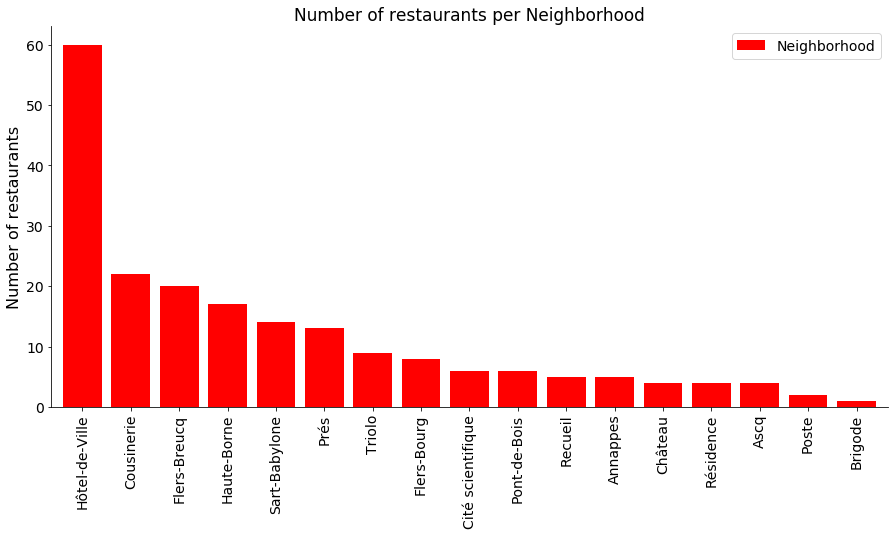

In [107]:
graph = numbersofrest.plot(kind='bar', figsize=(15, 7), width = 0.8, color = ('red'), fontsize = 14)
graph.set_title("Number of restaurants per Neighborhood", fontsize = 17)
graph.legend(fontsize = 14)
graph.spines['top'].set_visible(False)
graph.spines['right'].set_visible(False)
#plt.xlabel("Neighborhood", fontsize = 14)
plt.ylabel("Number of restaurants", fontsize = 16)
plt.legend(fontsize = 14)
plt.show()

### Now we\'ll see what are the most popular restaurant types in Villeneuve d\'Ascq

In [104]:
mostpoprest = vertical_stack_clean['Venue Category'].value_counts()
mostpoprest

French              70
Fast Food           30
Italian             19
Asian               10
Bakery              10
Cafe                 8
Barbecue & Grill     7
Restaurant           7
Gastropub            5
Japanese             5
Pizza Place          4
European             3
Mexican              3
Turkish              2
Brasserie            2
Healthy              2
Moroccan             2
American             2
International        1
Mediterranean        1
Belgian              1
Diner                1
Salad                1
Indian               1
Seafood              1
Eastern              1
Lebanese             1
Name: Venue Category, dtype: int64

#### This is how the word cloud representing these restaurants looks like:

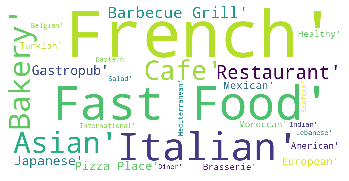

In [181]:
text = vertical_stack_clean['Venue Category'].values 
wordcloud = WordCloud(background_color="white", width=1000, height=500).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
wordcloud.to_file('1.png')
plt.show()

### And the bar graph is here

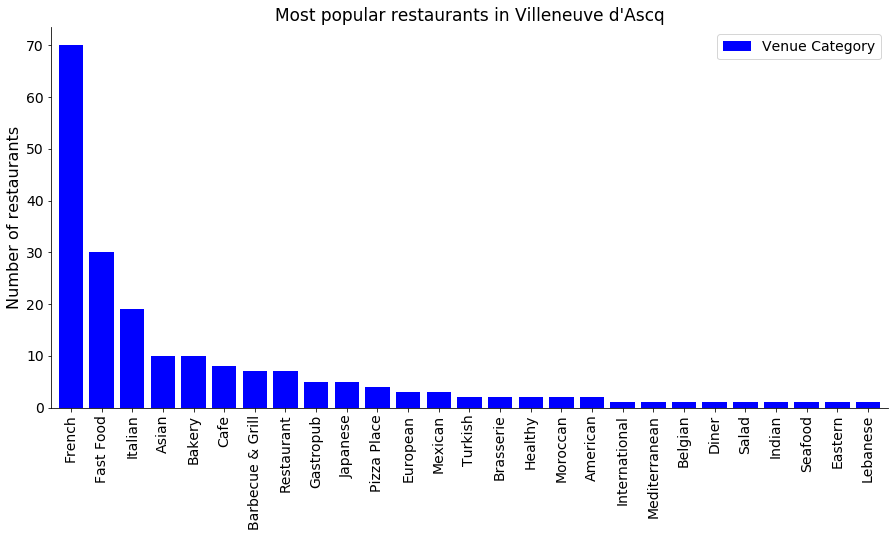

In [179]:
graph = mostpoprest.plot(kind='bar', figsize=(15, 7), width = 0.8, color = ('Blue'), fontsize = 14)
graph.set_title("Most popular restaurants in Villeneuve d'Ascq", fontsize = 17)
graph.legend(fontsize = 14)
graph.spines['top'].set_visible(False)
graph.spines['right'].set_visible(False)
#plt.xlabel("Neighborhood", fontsize = 14)
plt.ylabel("Number of restaurants", fontsize = 16)
plt.legend(fontsize = 14)
plt.show()

#### Now, let\'s see if there is any correlation between number of restaurants and population per neighborhood.
##### First, we'll merge two dataframes containing data we need.

In [105]:
restvspop=numbersofrest.to_frame()
restvspop=restvspop.reset_index()
restvspop = restvspop.rename(columns={"index": "Neighborhood", "Neighborhood": "Number_resto"}).sort_values(by=['Neighborhood']).reset_index(drop = True)
restvspop = pd.merge(restvspop, population, on='Neighborhood')
restvspop['Ratio'] = round(restvspop['Number_resto']*1000/restvspop['Population'], 2)  # number of restaurants per 1000 people
restvspop

,Neighborhood,Number_resto,Population,Ratio
0,Annappes,5,2794,1.79
1,Ascq,4,1774,2.25
2,Brigode,1,1208,0.83
3,Château,4,3030,1.32
4,Cité scientifique,6,4489,1.34
5,Cousinerie,22,7419,2.97
6,Flers-Bourg,8,4930,1.62
7,Flers-Breucq,20,1970,10.15
8,Haute-Borne,17,3725,4.56
9,Hôtel-de-Ville,60,5861,10.24


##### Then, we'll make a regression plot to see if there is any linear correlation between number of restaurants and number of people in neighborhood. 

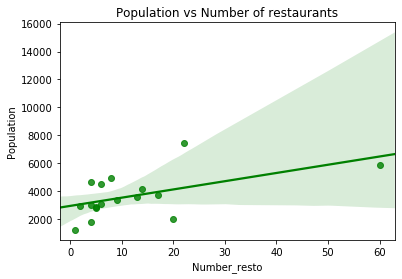

In [184]:
ax = sns.regplot(x='Number_resto', y='Population', data = restvspop, color = 'green').set_title('Population vs Number of restaurants').get_figure().savefig("regression.png")


##### Apparently, there is no correlation.

### Let\'s how the neighborhoods are distributed by the number of restaurants per 1000 people

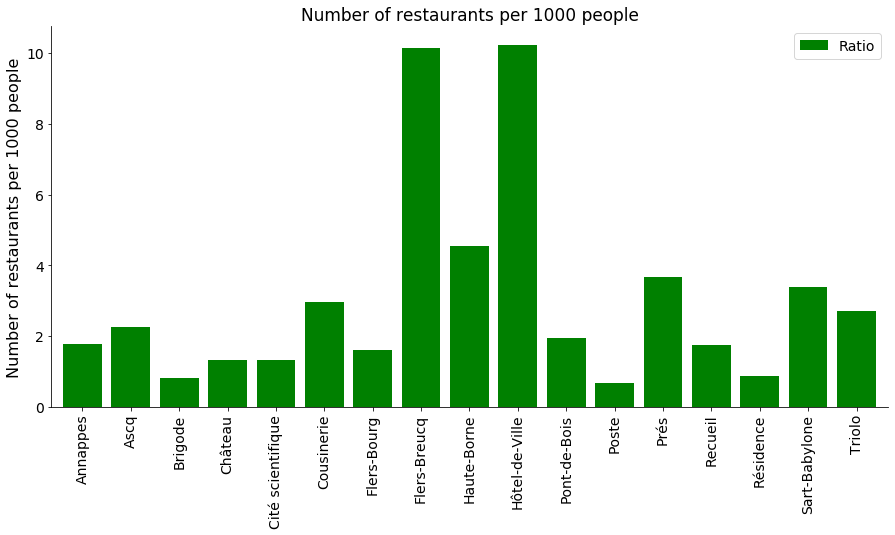

In [151]:
graph = restvspop.plot(kind='bar', x='Neighborhood', y='Ratio', figsize=(15, 7), width = 0.8, color = ('Green'), fontsize = 14)
graph.set_title("Number of restaurants per 1000 people", fontsize = 17)
graph.legend(fontsize = 14)
graph.spines['top'].set_visible(False)
graph.spines['right'].set_visible(False)
plt.xlabel("Neighborhood", fontsize = 14).set_visible(False)
plt.ylabel("Number of restaurants per 1000 people", fontsize = 16)
plt.legend(fontsize = 14)
plt.show()

#### And on the map it will look like this

In [106]:
map_vdascq = folium.Map(location=[50.6349, 3.1404], zoom_start=12)
for lat, lng, label, ratio in zip(neigh['latitude'], neigh['longitude'], neigh['Neighborhood'], restvspop['Ratio']):
    label = folium.Popup(label, parse_html=True)
    ra = 4*ratio
    folium.CircleMarker(
        [lat, lng],
        radius=ra,
        popup=label,
        color='darkred',
        fill=True,
        fill_color='red',
        fill_opacity=0.4,
        parse_html=False).add_to(map_vdascq)  
map_vdascq.save('map_vdascq.html')
map_vdascq

#### Now let\'s see how many unique categories we have.

In [107]:
print('There are {} uniques categories.'.format(len(vertical_stack_clean['Venue Category'].unique())))

There are 27 uniques categories.


In [108]:
master = vertical_stack_clean[['Neighborhood','Venue Category']]
master.head()

,Neighborhood,Venue Category
0,Haute-Borne,Barbecue & Grill
1,Flers-Breucq,Barbecue & Grill
2,Hôtel-de-Ville,Seafood
3,Flers-Bourg,French
4,Cousinerie,International


#### Let\'s Analyze Each Neighborhood by the food venue category
We'll use one hot encoding for this. It means we'll convert categorical variable into dummy/indicator variables

In [109]:
# one hot encoding
vdascq_onehot = pd.get_dummies(vertical_stack_clean[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vdascq_onehot['Neighborhood'] = vertical_stack_clean['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [vdascq_onehot.columns[-1]] + list(vdascq_onehot.columns[:-1])
vdascq_onehot = vdascq_onehot[fixed_columns]
print(vdascq_onehot.shape)
vdascq_onehot.head()

(200, 28)


,Neighborhood,American,Asian,Bakery,Barbecue & Grill,Belgian,Brasserie,Cafe,Diner,Eastern,European,Fast Food,French,Gastropub,Healthy,Indian,International,Italian,Japanese,Lebanese,Mediterranean,Mexican,Moroccan,Pizza Place,Restaurant,Salad,Seafood,Turkish
0,Haute-Borne,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Flers-Breucq,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Hôtel-de-Ville,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Flers-Bourg,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Cousinerie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


#### Now, let\'s see how many specific restaurants per neighborhood

In [110]:
tre = vdascq_onehot.groupby('Neighborhood').sum().reset_index()
tre.head()

,Neighborhood,American,Asian,Bakery,Barbecue & Grill,Belgian,Brasserie,Cafe,Diner,Eastern,European,Fast Food,French,Gastropub,Healthy,Indian,International,Italian,Japanese,Lebanese,Mediterranean,Mexican,Moroccan,Pizza Place,Restaurant,Salad,Seafood,Turkish
0,Annappes,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
1,Ascq,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Brigode,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Château,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,Cité scientifique,0,0,0,0,0,0,0,0,0,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Let\'s display to 5 restaurants in each neighborhood

In [111]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return (row_categories_sorted.index.values[0:num_top_venues]+ ' / ')*row_categories_sorted.values[0:num_top_venues]

In [112]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tre['Neighborhood']

for ind in np.arange(tre.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tre.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted   
 
neighborhoods_venues_sorted1 = neighborhoods_venues_sorted
neighborhoods_venues_sorted_columns = list(neighborhoods_venues_sorted.columns)[1:]
neighborhoods_venues_sorted_columns
for i in range(0, 5):
    col = neighborhoods_venues_sorted_columns[i]
    for j in range(0, len(neighborhoods_venues_sorted[col])):
        neighborhoods_venues_sorted1[col][j] = neighborhoods_venues_sorted1[col][j].split(' / ')[0]
neighborhoods_venues_sorted1 

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Annappes,French,Italian,,,
1,Ascq,French,Italian,,,
2,Brigode,French,,,,
3,Château,French,Restaurant,Japanese,Gastropub,
4,Cité scientifique,Fast Food,French,,,
5,Cousinerie,French,Fast Food,Bakery,Barbecue & Grill,Brasserie
6,Flers-Bourg,French,Restaurant,Bakery,Italian,
7,Flers-Breucq,French,Italian,Fast Food,Restaurant,Pizza Place
8,Haute-Borne,French,Fast Food,Asian,Restaurant,Pizza Place
9,Hôtel-de-Ville,French,Asian,Italian,Fast Food,Cafe


## Neighborhodd clustering
#### We'll use k-means clustering.
##### First, we'll find the optimal number of clusters using Elbow method

In [113]:
distortions = []
vdascq_grouped_clustering = tre.drop('Neighborhood', 1)
K = range(1,17)
for k in K:
    print(k, end = ' ')
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(vdascq_grouped_clustering)
    distortions.append(kmeanModel.inertia_)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 

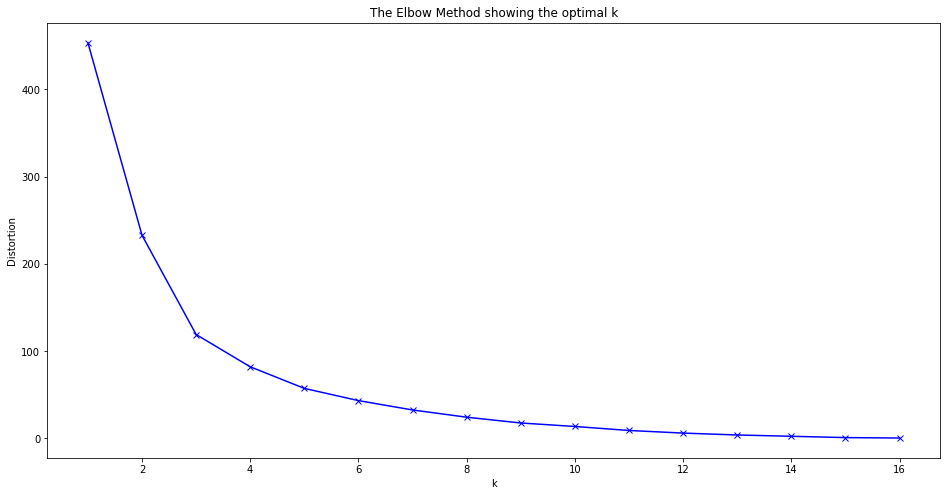

In [191]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Here we see, that the optimal number of clusters is 3
##### So, let\'s do our clustering

In [114]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(vdascq_grouped_clustering)
labels = k_means.labels_
print(labels)


[0 0 0 0 0 1 0 1 1 2 0 0 1 0 0 0 0]


In [115]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)

vdascq_merged = neigh[['Neighborhood']]
vdascq_merged = vdascq_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

vdascq_merged # check the last columns!



,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Annappes,0,French,Italian,,,
1,Ascq,0,French,Italian,,,
2,Brigode,0,French,,,,
3,Château,0,French,Restaurant,Japanese,Gastropub,
4,Cité scientifique,0,Fast Food,French,,,
5,Cousinerie,1,French,Fast Food,Bakery,Barbecue & Grill,Brasserie
6,Flers-Bourg,0,French,Restaurant,Bakery,Italian,
7,Flers-Breucq,1,French,Italian,Fast Food,Restaurant,Pizza Place
8,Haute-Borne,1,French,Fast Food,Asian,Restaurant,Pizza Place
9,Hôtel-de-Ville,2,French,Asian,Italian,Fast Food,Cafe


#### Now, we\'ll visualize our clusters on map

In [117]:
# create map
map_vdascq_clusters = folium.Map(location=[50.6349, 3.1404], zoom_start=13)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 3, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, ratio in zip(neigh['latitude'], neigh['longitude'], vdascq_merged['Neighborhood'], vdascq_merged['Cluster Labels'], restvspop['Ratio']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    ra = 4*ratio
    folium.CircleMarker(
        [lat, lon],
        radius=ra,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_vdascq_clusters)
       
map_vdascq_clusters.save('map_vdascq.html')
map_vdascq_clusters

## Cluster analysis
#### Now, we\'ll see how different our 3 clusters are.

In [60]:
vdascq_merged_columns = list(vdascq_merged.columns)[2:]



### Cluster 0

In [61]:
cluster0 = vdascq_merged.loc[vdascq_merged['Cluster Labels'] == 0, vdascq_merged.columns[[0] + list(range(2, vdascq_merged.shape[1]))]].reset_index(drop = True)
cluster0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Annappes,French,Italian,,,
1,Ascq,French,Italian,,,
2,Brigode,French,,,,
3,Château,French,Restaurant,Japanese,Gastropub,
4,Cité scientifique,Fast Food,French,,,
5,Flers-Bourg,French,Restaurant,Bakery,Italian,
6,Pont-de-Bois,Cafe,French,Gastropub,Fast Food,
7,Poste,French,,,,
8,Recueil,French,Brasserie,Eastern,,
9,Résidence,French,Restaurant,Italian,,


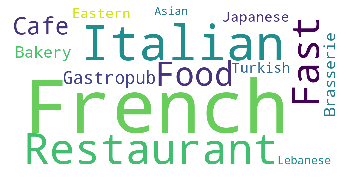

In [198]:
text = []
for i in range(0, 5):
    col = vdascq_merged_columns[i]
    for j in range(0, len(cluster0['Neighborhood'])):
        #a = (cluster0[col][j] + ' ')*(5-i)
        for k in range (0, 5-i):
            text.append(cluster0[col][j])

text1=(" ").join(text)
wordcloud = WordCloud(background_color="white", width=1000, height=500, collocations = False).generate(str(text1))
plt.imshow(wordcloud)
plt.axis("off")
wordcloud.to_file('cluster0.png')
plt.show()    

## Cluster 1

In [134]:
cluster1 = vdascq_merged.loc[vdascq_merged['Cluster Labels'] == 1, vdascq_merged.columns[[0] + list(range(2, vdascq_merged.shape[1]))]].reset_index(drop = True)
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Hôtel-de-Ville,French,Asian,Italian,Fast Food,Cafe


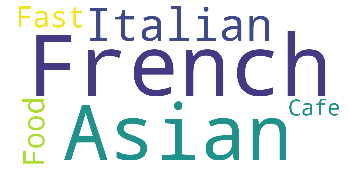

In [199]:
text = []
for i in range(0, 5):
    col = vdascq_merged_columns[i]
    for j in range(0, len(cluster1['Neighborhood'])):
        #a = (cluster0[col][j] + ' ')*(5-i)
        for k in range (0, 5-i):
            text.append(cluster1[col][j])

text1=(" ").join(text)
wordcloud = WordCloud(background_color="white", width=1000, height=500, collocations = False).generate(str(text1))
plt.imshow(wordcloud)
plt.axis("off")
wordcloud.to_file('cluster1.png')
plt.show()

## Cluster 2

In [136]:
cluster2 = vdascq_merged.loc[vdascq_merged['Cluster Labels'] == 2, vdascq_merged.columns[[0] + list(range(2, vdascq_merged.shape[1]))]].reset_index(drop = True)
cluster2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Cousinerie,French,Fast Food,Bakery,Barbecue & Grill,Brasserie
1,Flers-Breucq,French,Italian,Fast Food,Restaurant,Pizza Place
2,Haute-Borne,French,Fast Food,Asian,Restaurant,Pizza Place
3,Prés,French,Fast Food,Bakery,Barbecue & Grill,Italian


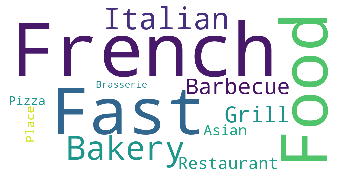

In [200]:
text = []
for i in range(0, 5):
    col = vdascq_merged_columns[i]
    for j in range(0, len(cluster2['Neighborhood'])):
        #a = (cluster0[col][j] + ' ')*(5-i)
        for k in range (0, 5-i):
            text.append(cluster2[col][j])

text1=(" ").join(text)
wordcloud = WordCloud(background_color="white", width=1000, height=500, collocations = False).generate(str(text1))
plt.imshow(wordcloud)
plt.axis("off")
wordcloud.to_file('cluster2.png')
plt.show()